In [1]:
import warnings
warnings.filterwarnings("ignore")
import os,logging
logging.disable(logging.WARNING)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Workspace problem with several narrow gaps
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time
import pathlib
# import cv2
config = tf.ConfigProto()
config.gpu_options.allow_growth=True

In [3]:
tf.test.is_gpu_available()

True

# Clarification
Due to the loading of the array in MATLAB is transposed, column wise and not row wise, the data generated is of the format ```(y_sample,x_sample,y_init,x_init)```
Therefore the needful must be done to properly visualise the sampled points.

In [4]:
# STATE_DIM = 2  # state dimension x, y
# VALS_PER_SAMPLE = 6  # number of numbers per training sample
# SAMPLE_SCALE_UP = 160
# MAP_NUM = 5  # which map training on
# DATA_ROOT = './Training_Data'
# MODEL_DIR = './Models/0'+str(MAP_NUM)
# # Parse sampling data
# samples_file = os.path.join(DATA_ROOT, 'nodes_{}.txt'.format(MAP_NUM))
# with open(samples_file, 'r') as f:
#   txt_rows = f.read().split("\n")
#   data_list = []
#   for row in txt_rows:
#     new_data = []
#     for val in row.split(" "):
#       try:
#         num = float(val)
#         new_data.append(num)
#       except ValueError:
#         continue
#     if len(new_data) == VALS_PER_SAMPLE:
#       data_list.append(new_data)
#     else:
#       print("Error parsing a line: %s" % row)
# sample_data = np.array(data_list,dtype='float')

# # Load original map that was sampled from
# orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(MAP_NUM))
# orig_map = np.load(orig_map_file)

# # Parse mini map that was sampled from for training
# mini_map_file = os.path.join(DATA_ROOT, 'map{}_mini.npy'.format(MAP_NUM))
# map_data = np.load(mini_map_file)
# print("Done!")




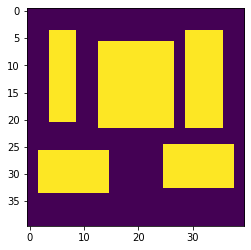

In [6]:
# NOTE: State Format is (ROW, COL, THETA): [sy, sx, st, iy, ix, iz, gy, gx, gt]!!!!!!!!
STATE_DIM = 3  # state dimension x, y, theta
VALS_PER_SAMPLE = 3 * STATE_DIM  # (sample, init, goal) * STATE_DIM
SAMPLE_SCALE_UP = 160
DATA_ROOT = './Training_Data'
MODEL_DIR = './Models/Unified_1'

# Parse sampling data
train_map_ids = [3,4,5] # [1, 3, 4, 5, 6]
test_map_ids = [2, 7]  # used later for testing
train_maps = dict()
all_orig_maps = dict()
all_data = np.array([], dtype=np.float).reshape(0,VALS_PER_SAMPLE + 40*40)
for map_num in train_map_ids:
  mini_map_file = os.path.join(DATA_ROOT, 'map{}_mini.npy'.format(map_num))
  map_data = np.load(mini_map_file)

  orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(map_num))
  all_orig_maps[map_num] = np.load(orig_map_file)

  unrolled_map = np.concatenate(map_data, axis=0)
  train_maps[map_num] = unrolled_map
  unrolled_map = unrolled_map.reshape(1,len(unrolled_map))  # 1 x N^2

  plt.imshow(map_data * 255)
  
  samples_file = os.path.join(DATA_ROOT, 'map{}_training.npz'.format(map_num))
  samples_data = np.array(np.load(samples_file)['data'])
  num_samples = samples_data.shape[0]

  # dubplicates unrolleded map from 1xN^2 into MxN^2 where M = num_samples
  # then appends to samples so each sample row has unrolled map
  train_data = np.hstack([samples_data, np.repeat(unrolled_map, num_samples, axis=0)])

  # append to bottom of all_data matrix of size KxN^2
  all_data = np.concatenate([all_data, train_data], axis=0)
  

# shuffle data to not bias by order of maps
np.random.shuffle(all_data)


# Don't load these in case the above step takes up too much RAM
# # Load original map that was sampled from
# orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(MAP_NUM))
# orig_map = np.load(orig_map_file)

# # Parse mini map that was sampled from for training
# mini_map_file = os.path.join(DATA_ROOT, 'map{}_mini.npy'.format(MAP_NUM))
# map_data = np.load(mini_map_file)
# print("Done!")


In [7]:
all_data.shape

(10815, 1609)

Network Hyperparameters

In [8]:
# # neural network parameters
# mb_size = 256  # mini batch GD size
# h_Q_dim = 512
# h_P_dim = 512
# z_dim = 3 # latent
# c = 0  # 
# lr = 1e-4  # learning rate
# state_weights = [[1, 1]]  # both states (x,y) are equally important
# TRAIN_ITERS = 500000
# ITERS_PER_SAVE = 10000

# # split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
# ratioTestTrain = 0.8
# numEntries = sample_data.shape[0]
# numTrain = int(numEntries*ratioTestTrain)
# numTest = numEntries - numTrain

# # x_train and x_test are the samples from solved paths
# x_train = sample_data[:numTrain, :STATE_DIM] # state: row, col
# x_test = sample_data[numTrain:, :STATE_DIM]  # other part of data

# # cond_data 1D array of concatenated [init, goal, map]
# unrolled_map = np.concatenate(map_data, axis=0)
# COND_DIM = STATE_DIM + STATE_DIM + len(unrolled_map)  # init + goal + map
# cond_data = np.zeros((numEntries, COND_DIM))
# for r in range(numEntries):
#   cond_data[r,:] = np.concatenate([sample_data[r,STATE_DIM:], unrolled_map], axis=0)

# cond_train = cond_data[:numTrain, :]
# cond_test = cond_data[numTrain:, :]

In [11]:
# neural network parameters
mb_size = 256  # mini batch GD size
h_Q_dim = 512
h_P_dim = 512
z_dim = 3 # latent
c = 0  # 
lr = 1e-4  # learning rate
state_weights = [[1, 1, 0.5]]  # both states (x,y, theta) are equally important
assert(len(state_weights[0]) == STATE_DIM)  # cost weight of each state!
TRAIN_ITERS = 500000
ITERS_PER_SAVE = 10000

# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 1
numEntries = all_data.shape[0]
numTrain = int(numEntries*ratioTestTrain)
numTest = numEntries - numTrain

# x_train and x_test are the samples from solved paths
x_train = all_data[:numTrain, :STATE_DIM] # state: x, y, theta
x_test = all_data[numTrain:, :STATE_DIM]  # other part of data

# conditional data
COND_DIM = all_data.shape[1] - STATE_DIM  # (init, goal, unrolled_map)
cond_train = all_data[:numTrain, STATE_DIM:]
cond_test = all_data[numTrain:, STATE_DIM:]

In [12]:
# # Load original map that was sampled from and print any collisions
# orig_map_file = os.path.join(DATA_ROOT, 'map{}.npy'.format(5))
# orig_map = np.load(orig_map_file)
# plt.imshow(orig_map)
# plt.scatter(x=x_train[:,1]*SAMPLE_SCALE_UP, y=x_train[:,0]*SAMPLE_SCALE_UP, color="red", s=0.5,) # init
# plt.show()
# x=x_train[:,0]*SAMPLE_SCALE_UP
# y=x_train[:,1]*SAMPLE_SCALE_UP
# for i,j in zip(x_train[:,0],x_train[:,1]):
#   if orig_map[int(i*SAMPLE_SCALE_UP),int(j*SAMPLE_SCALE_UP)]==1:
#     print(i,j)
#     print(i*SAMPLE_SCALE_UP,j*SAMPLE_SCALE_UP)

# Training
To rename output tensors ``` tf.identity(z, name="z")``` 

In [13]:
# define networks
X = tf.placeholder(tf.float32, shape=[None, STATE_DIM], name="X")
c = tf.placeholder(tf.float32, shape=[None, COND_DIM], name="c")

# Q (Encoder)
inputs_Q = tf.concat(axis=1, values=[X,c])

dense_Q1 = tf.layers.dense(inputs=inputs_Q, units=h_Q_dim, activation=tf.nn.relu)
dropout_Q1 = tf.layers.dropout(inputs=dense_Q1, rate=0.5)
dense_Q2 = tf.layers.dense(inputs=dropout_Q1, units=h_Q_dim, activation=tf.nn.relu)

z_mu = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_mu
z_logvar = tf.layers.dense(inputs=dense_Q2, units=z_dim) # output here is z_logvar

# P (Reparameterisation tricks)
eps = tf.random_normal(shape=tf.shape(z_mu))
z = tf.add(z_mu, tf.exp(z_logvar / 2) * eps)
inputs_P = tf.concat(axis=1, values=[z,c])

# (Decoder)
dense_P1 = tf.layers.dense(inputs=inputs_P, units=h_P_dim, activation=tf.nn.relu)
dropout_P1 = tf.layers.dropout(inputs=dense_P1, rate=0.5)
dense_P2 = tf.layers.dense(inputs=dropout_P1, units=h_P_dim, activation=tf.nn.relu)

y = tf.layers.dense(inputs=dense_P2, units=STATE_DIM) # fix to also output y

# training
recon_loss = tf.losses.mean_squared_error(labels=X, predictions=y, weights=state_weights)
# TODO: fix loss function for angles going around
kl_loss = 10**-4 * 2 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

cvae_loss = tf.reduce_mean(kl_loss + recon_loss)

train_step = tf.train.AdamOptimizer(lr).minimize(cvae_loss)

sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())
tf.train.export_meta_graph(MODEL_DIR+'/graph.meta')
it = 0;

Iter: 0
Loss: 0.6352



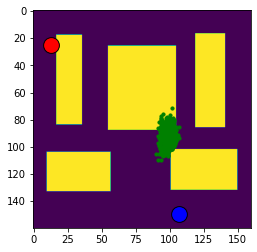

Iter: 1000
Loss: 0.02959

Iter: 2000
Loss: 0.01294

Iter: 3000
Loss: 0.005465

Iter: 4000
Loss: 0.00686

Iter: 5000
Loss: 0.005362

Iter: 6000
Loss: 0.00482

Iter: 7000
Loss: 0.004762

Iter: 8000
Loss: 0.006687

Iter: 9000
Loss: 0.005199

Iter: 10000
Loss: 0.004999



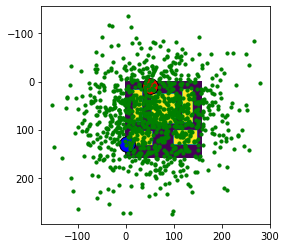

Iter: 11000
Loss: 0.004878

Iter: 12000
Loss: 0.00493

Iter: 13000
Loss: 0.006513

Iter: 14000
Loss: 0.004503

Iter: 15000
Loss: 0.004666

Iter: 16000
Loss: 0.004813

Iter: 17000
Loss: 0.004781

Iter: 18000
Loss: 0.005704

Iter: 19000
Loss: 0.005251

Iter: 20000
Loss: 0.004557



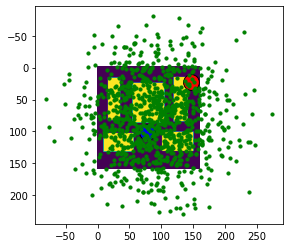

Iter: 21000
Loss: 0.00466

Iter: 22000
Loss: 0.005338

Iter: 23000
Loss: 0.005054

Iter: 24000
Loss: 0.00462

Iter: 25000
Loss: 0.004702

Iter: 26000
Loss: 0.00475

Iter: 27000
Loss: 0.004685

Iter: 28000
Loss: 0.00473

Iter: 29000
Loss: 0.004439

Iter: 30000
Loss: 0.004371



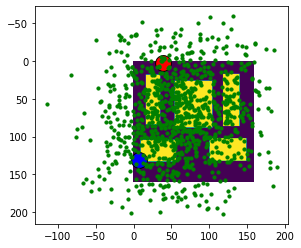

Iter: 31000
Loss: 0.004787

Iter: 32000
Loss: 0.004813

Iter: 33000
Loss: 0.004284

Iter: 34000
Loss: 0.004679

Iter: 35000
Loss: 0.004233

Iter: 36000
Loss: 0.004544

Iter: 37000
Loss: 0.004287

Iter: 38000
Loss: 0.004379

Iter: 39000
Loss: 0.004336

Iter: 40000
Loss: 0.004442



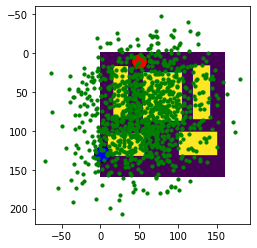

Iter: 41000
Loss: 0.004186

Iter: 42000
Loss: 0.004352

Iter: 43000
Loss: 0.005511

Iter: 44000
Loss: 0.004023

Iter: 45000
Loss: 0.004186

Iter: 46000
Loss: 0.004043

Iter: 47000
Loss: 0.004195

Iter: 48000
Loss: 0.003977

Iter: 49000
Loss: 0.003916

Iter: 50000
Loss: 0.004003



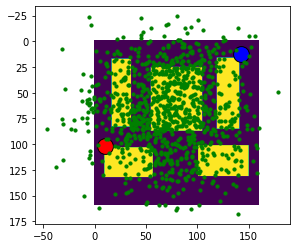

Iter: 51000
Loss: 0.004829

Iter: 52000
Loss: 0.003935

Iter: 53000
Loss: 0.003872

Iter: 54000
Loss: 0.003942

Iter: 55000
Loss: 0.004025

Iter: 56000
Loss: 0.004419

Iter: 57000
Loss: 0.004795

Iter: 58000
Loss: 0.004273

Iter: 59000
Loss: 0.003972

Iter: 60000
Loss: 0.004051



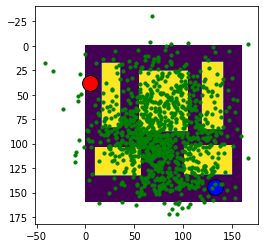

Iter: 61000
Loss: 0.004251

Iter: 62000
Loss: 0.003973

Iter: 63000
Loss: 0.003947

Iter: 64000
Loss: 0.004596

Iter: 65000
Loss: 0.003947

Iter: 66000
Loss: 0.004388

Iter: 67000
Loss: 0.003865

Iter: 68000
Loss: 0.004227

Iter: 69000
Loss: 0.004047

Iter: 70000
Loss: 0.003799



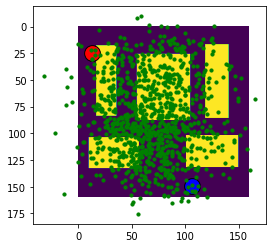

Iter: 71000
Loss: 0.004213

Iter: 72000
Loss: 0.003944

Iter: 73000
Loss: 0.004003

Iter: 74000
Loss: 0.003887

Iter: 75000
Loss: 0.003888

Iter: 76000
Loss: 0.003878

Iter: 77000
Loss: 0.003853

Iter: 78000
Loss: 0.003824

Iter: 79000
Loss: 0.003817

Iter: 80000
Loss: 0.004317



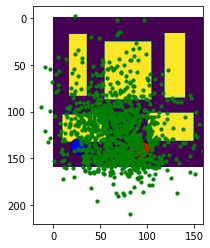

Iter: 81000
Loss: 0.003871

Iter: 82000
Loss: 0.00386

Iter: 83000
Loss: 0.004049

Iter: 84000
Loss: 0.003802

Iter: 85000
Loss: 0.003945

Iter: 86000
Loss: 0.004094

Iter: 87000
Loss: 0.004442

Iter: 88000
Loss: 0.003917

Iter: 89000
Loss: 0.003716

Iter: 90000
Loss: 0.004097



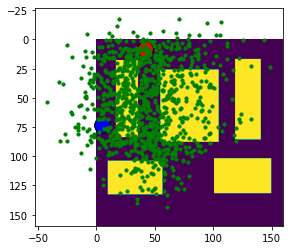

Iter: 91000
Loss: 0.003747

Iter: 92000
Loss: 0.003791

Iter: 93000
Loss: 0.003788

Iter: 94000
Loss: 0.003909

Iter: 95000
Loss: 0.003611

Iter: 96000
Loss: 0.003838

Iter: 97000
Loss: 0.003909

Iter: 98000
Loss: 0.003739

Iter: 99000
Loss: 0.003886

Iter: 100000
Loss: 0.003806



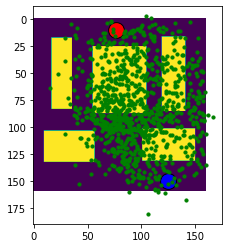

Iter: 101000
Loss: 0.003787

Iter: 102000
Loss: 0.003779

Iter: 103000
Loss: 0.003842

Iter: 104000
Loss: 0.004475

Iter: 105000
Loss: 0.003774

Iter: 106000
Loss: 0.003993

Iter: 107000
Loss: 0.004084

Iter: 108000
Loss: 0.003897

Iter: 109000
Loss: 0.003968

Iter: 110000
Loss: 0.00384



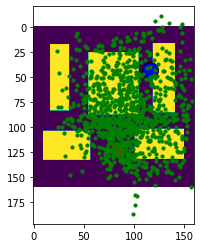

Iter: 111000
Loss: 0.003859

Iter: 112000
Loss: 0.003726

Iter: 113000
Loss: 0.003794

Iter: 114000
Loss: 0.003794

Iter: 115000
Loss: 0.003877

Iter: 116000
Loss: 0.003872

Iter: 117000
Loss: 0.003649

Iter: 118000
Loss: 0.003686

Iter: 119000
Loss: 0.003885

Iter: 120000
Loss: 0.003645



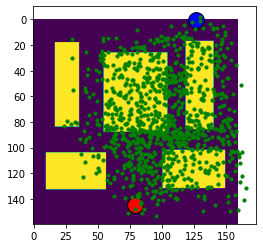

Iter: 121000
Loss: 0.003648

Iter: 122000
Loss: 0.003681

Iter: 123000
Loss: 0.003698

Iter: 124000
Loss: 0.003872

Iter: 125000
Loss: 0.003826

Iter: 126000
Loss: 0.003848

Iter: 127000
Loss: 0.004044

Iter: 128000
Loss: 0.0036

Iter: 129000
Loss: 0.003874

Iter: 130000
Loss: 0.003786



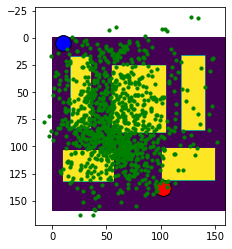

Iter: 131000
Loss: 0.003638

Iter: 132000
Loss: 0.00364

Iter: 133000
Loss: 0.003734

Iter: 134000
Loss: 0.003734

Iter: 135000
Loss: 0.003891

Iter: 136000
Loss: 0.003693

Iter: 137000
Loss: 0.003758

Iter: 138000
Loss: 0.003751

Iter: 139000
Loss: 0.003738

Iter: 140000
Loss: 0.004014



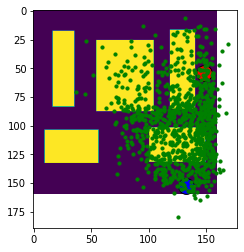

Iter: 141000
Loss: 0.003733

Iter: 142000
Loss: 0.003839

Iter: 143000
Loss: 0.003587

Iter: 144000
Loss: 0.003821

Iter: 145000
Loss: 0.003579

Iter: 146000
Loss: 0.003576

Iter: 147000
Loss: 0.003531

Iter: 148000
Loss: 0.003627

Iter: 149000
Loss: 0.003564

Iter: 150000
Loss: 0.003708



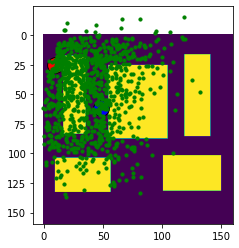

Iter: 151000
Loss: 0.003531

Iter: 152000
Loss: 0.003651

Iter: 153000
Loss: 0.003503

Iter: 154000
Loss: 0.00375

Iter: 155000
Loss: 0.003572

Iter: 156000
Loss: 0.003451

Iter: 157000
Loss: 0.003569

Iter: 158000
Loss: 0.003869

Iter: 159000
Loss: 0.0039

Iter: 160000
Loss: 0.003485



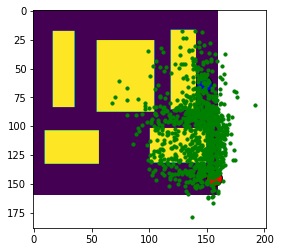

Iter: 161000
Loss: 0.00372

Iter: 162000
Loss: 0.003605

Iter: 163000
Loss: 0.003579

Iter: 164000
Loss: 0.003675

Iter: 165000
Loss: 0.003782

Iter: 166000
Loss: 0.003708

Iter: 167000
Loss: 0.003512

Iter: 168000
Loss: 0.003629

Iter: 169000
Loss: 0.003521

Iter: 170000
Loss: 0.003808



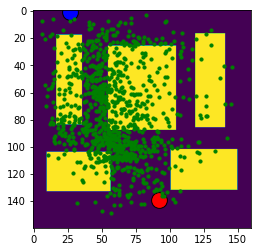

Iter: 171000
Loss: 0.003464

Iter: 172000
Loss: 0.003667

Iter: 173000
Loss: 0.00392

Iter: 174000
Loss: 0.003463

Iter: 175000
Loss: 0.003462

Iter: 176000
Loss: 0.003484

Iter: 177000
Loss: 0.00362

Iter: 178000
Loss: 0.003522

Iter: 179000
Loss: 0.003545

Iter: 180000
Loss: 0.003706



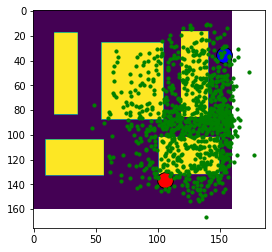

Iter: 181000
Loss: 0.003498

Iter: 182000
Loss: 0.003651

Iter: 183000
Loss: 0.003696

Iter: 184000
Loss: 0.003437

Iter: 185000
Loss: 0.003456

Iter: 186000
Loss: 0.003552

Iter: 187000
Loss: 0.003561

Iter: 188000
Loss: 0.003417

Iter: 189000
Loss: 0.003357

Iter: 190000
Loss: 0.003478



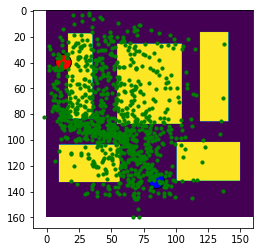

Iter: 191000
Loss: 0.003558

Iter: 192000
Loss: 0.003666

Iter: 193000
Loss: 0.003516

Iter: 194000
Loss: 0.003537

Iter: 195000
Loss: 0.003464

Iter: 196000
Loss: 0.003552

Iter: 197000
Loss: 0.003481

Iter: 198000
Loss: 0.003647

Iter: 199000
Loss: 0.003638

Iter: 200000
Loss: 0.003446



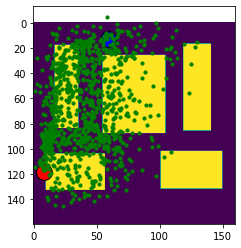

Iter: 201000
Loss: 0.003483

Iter: 202000
Loss: 0.003376

Iter: 203000
Loss: 0.003567

Iter: 204000
Loss: 0.003405

Iter: 205000
Loss: 0.003472

Iter: 206000
Loss: 0.00342

Iter: 207000
Loss: 0.00346

Iter: 208000
Loss: 0.003438

Iter: 209000
Loss: 0.003451

Iter: 210000
Loss: 0.003434



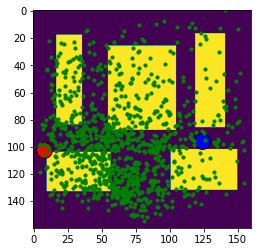

Iter: 211000
Loss: 0.003598

Iter: 212000
Loss: 0.003376

Iter: 213000
Loss: 0.00385

Iter: 214000
Loss: 0.003432

Iter: 215000
Loss: 0.003359

Iter: 216000
Loss: 0.003801

Iter: 217000
Loss: 0.00357

Iter: 218000
Loss: 0.003445

Iter: 219000
Loss: 0.003397

Iter: 220000
Loss: 0.003349



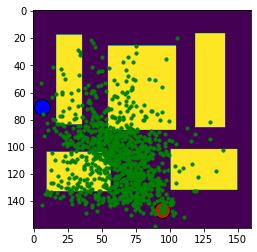

Iter: 221000
Loss: 0.003645

Iter: 222000
Loss: 0.003367

Iter: 223000
Loss: 0.003482

Iter: 224000
Loss: 0.00344

Iter: 225000
Loss: 0.003475

Iter: 226000
Loss: 0.003309

Iter: 227000
Loss: 0.00332

Iter: 228000
Loss: 0.003513

Iter: 229000
Loss: 0.003295

Iter: 230000
Loss: 0.003408



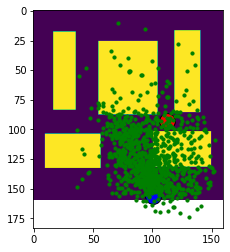

Iter: 231000
Loss: 0.0034

Iter: 232000
Loss: 0.003344

Iter: 233000
Loss: 0.003547

Iter: 234000
Loss: 0.00337

Iter: 235000
Loss: 0.003356

Iter: 236000
Loss: 0.003554

Iter: 237000
Loss: 0.003326

Iter: 238000
Loss: 0.003651

Iter: 239000
Loss: 0.003661

Iter: 240000
Loss: 0.003544



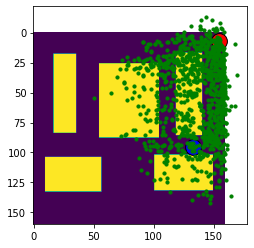

Iter: 241000
Loss: 0.003308

Iter: 242000
Loss: 0.003315

Iter: 243000
Loss: 0.003334

Iter: 244000
Loss: 0.00327

Iter: 245000
Loss: 0.003379

Iter: 246000
Loss: 0.003378

Iter: 247000
Loss: 0.003492

Iter: 248000
Loss: 0.003352

Iter: 249000
Loss: 0.003494

Iter: 250000
Loss: 0.003312



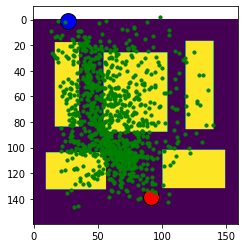

Iter: 251000
Loss: 0.003383

Iter: 252000
Loss: 0.003496

Iter: 253000
Loss: 0.003456

Iter: 254000
Loss: 0.003396

Iter: 255000
Loss: 0.003356

Iter: 256000
Loss: 0.003505

Iter: 257000
Loss: 0.003295

Iter: 258000
Loss: 0.003306

Iter: 259000
Loss: 0.00347

Iter: 260000
Loss: 0.00331



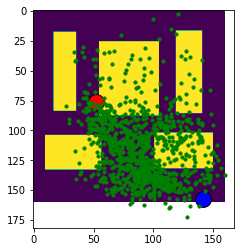

Iter: 261000
Loss: 0.003417

Iter: 262000
Loss: 0.003181

Iter: 263000
Loss: 0.003324

Iter: 264000
Loss: 0.003264

Iter: 265000
Loss: 0.00353

Iter: 266000
Loss: 0.003258

Iter: 267000
Loss: 0.003368

Iter: 268000
Loss: 0.00325

Iter: 269000
Loss: 0.003298

Iter: 270000
Loss: 0.003485



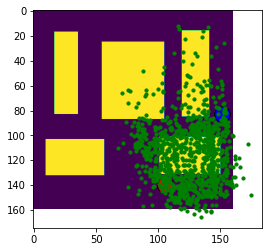

Iter: 271000
Loss: 0.003269

Iter: 272000
Loss: 0.003413

Iter: 273000
Loss: 0.003339

Iter: 274000
Loss: 0.00396

Iter: 275000
Loss: 0.003342

Iter: 276000
Loss: 0.003494

Iter: 277000
Loss: 0.003545

Iter: 278000
Loss: 0.003279

Iter: 279000
Loss: 0.003261

Iter: 280000
Loss: 0.003225



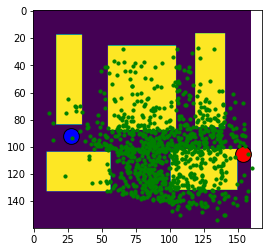

Iter: 281000
Loss: 0.003174

Iter: 282000
Loss: 0.003195

Iter: 283000
Loss: 0.003354

Iter: 284000
Loss: 0.003134

Iter: 285000
Loss: 0.00326

Iter: 286000
Loss: 0.00345

Iter: 287000
Loss: 0.003369

Iter: 288000
Loss: 0.003201

Iter: 289000
Loss: 0.003344

Iter: 290000
Loss: 0.003493



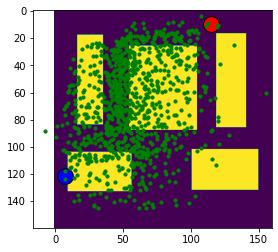

Iter: 291000
Loss: 0.003222

Iter: 292000
Loss: 0.003227

Iter: 293000
Loss: 0.003309

Iter: 294000
Loss: 0.003203

Iter: 295000
Loss: 0.003338

Iter: 296000
Loss: 0.003174

Iter: 297000
Loss: 0.003183

Iter: 298000
Loss: 0.003207

Iter: 299000
Loss: 0.003282

Iter: 300000
Loss: 0.003166



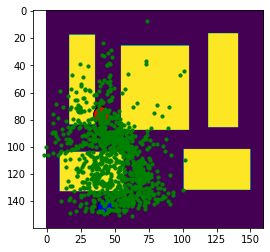

Iter: 301000
Loss: 0.003233

Iter: 302000
Loss: 0.003185

Iter: 303000
Loss: 0.003372

Iter: 304000
Loss: 0.003179

Iter: 305000
Loss: 0.003312

Iter: 306000
Loss: 0.003236

Iter: 307000
Loss: 0.003126

Iter: 308000
Loss: 0.00327

Iter: 309000
Loss: 0.003136

Iter: 310000
Loss: 0.003175



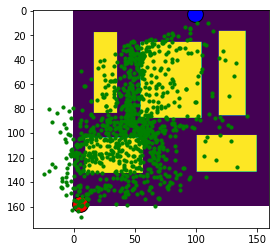

Iter: 311000
Loss: 0.003127

Iter: 312000
Loss: 0.003192

Iter: 313000
Loss: 0.003471

Iter: 314000
Loss: 0.003214

Iter: 315000
Loss: 0.003194

Iter: 316000
Loss: 0.003415

Iter: 317000
Loss: 0.003096

Iter: 318000
Loss: 0.003215

Iter: 319000
Loss: 0.003272

Iter: 320000
Loss: 0.00314



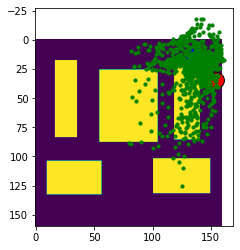

Iter: 321000
Loss: 0.003109

Iter: 322000
Loss: 0.003091

Iter: 323000
Loss: 0.003097

Iter: 324000
Loss: 0.003241

Iter: 325000
Loss: 0.00329

Iter: 326000
Loss: 0.003291

Iter: 327000
Loss: 0.003226

Iter: 328000
Loss: 0.00327

Iter: 329000
Loss: 0.003163

Iter: 330000
Loss: 0.00327



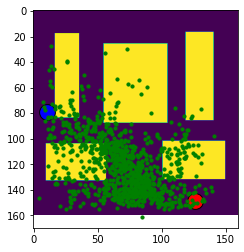

Iter: 331000
Loss: 0.003221

Iter: 332000
Loss: 0.003146

Iter: 333000
Loss: 0.003284

Iter: 334000
Loss: 0.00319

Iter: 335000
Loss: 0.003207

Iter: 336000
Loss: 0.003311

Iter: 337000
Loss: 0.003272

Iter: 338000
Loss: 0.00317

Iter: 339000
Loss: 0.003164

Iter: 340000
Loss: 0.003214



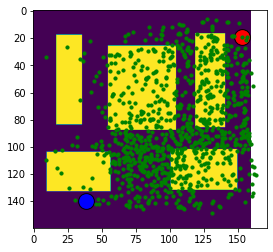

Iter: 341000
Loss: 0.003223

Iter: 342000
Loss: 0.003148

Iter: 343000
Loss: 0.003287

Iter: 344000
Loss: 0.003384

Iter: 345000
Loss: 0.003418

Iter: 346000
Loss: 0.003363

Iter: 347000
Loss: 0.003159

Iter: 348000
Loss: 0.003401

Iter: 349000
Loss: 0.003223

Iter: 350000
Loss: 0.003143



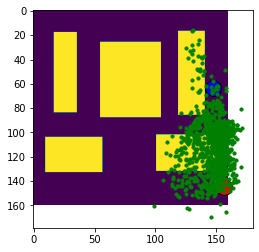

Iter: 351000
Loss: 0.003192

Iter: 352000
Loss: 0.003051

Iter: 353000
Loss: 0.003167

Iter: 354000
Loss: 0.003141

Iter: 355000
Loss: 0.003078

Iter: 356000
Loss: 0.003046

Iter: 357000
Loss: 0.003179

Iter: 358000
Loss: 0.003301

Iter: 359000
Loss: 0.003051

Iter: 360000
Loss: 0.00313



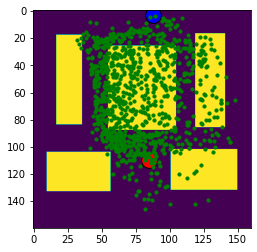

Iter: 361000
Loss: 0.00304

Iter: 362000
Loss: 0.003199

Iter: 363000
Loss: 0.003127

Iter: 364000
Loss: 0.003077

Iter: 365000
Loss: 0.003178

Iter: 366000
Loss: 0.003063

Iter: 367000
Loss: 0.003036

Iter: 368000
Loss: 0.003239

Iter: 369000
Loss: 0.003069

Iter: 370000
Loss: 0.002974



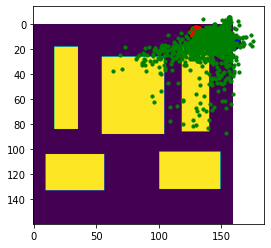

Iter: 371000
Loss: 0.003205

Iter: 372000
Loss: 0.00298

Iter: 373000
Loss: 0.003091

Iter: 374000
Loss: 0.003063

Iter: 375000
Loss: 0.00313

Iter: 376000
Loss: 0.003101

Iter: 377000
Loss: 0.003245

Iter: 378000
Loss: 0.003125

Iter: 379000
Loss: 0.003013

Iter: 380000
Loss: 0.003381



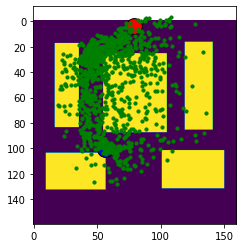

Iter: 381000
Loss: 0.003159

Iter: 382000
Loss: 0.003145

Iter: 383000
Loss: 0.003146

Iter: 384000
Loss: 0.003276

Iter: 385000
Loss: 0.00314

Iter: 386000
Loss: 0.003029

Iter: 387000
Loss: 0.003089

Iter: 388000
Loss: 0.003047

Iter: 389000
Loss: 0.003019

Iter: 390000
Loss: 0.003075



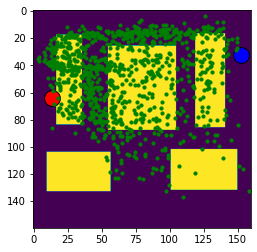

Iter: 391000
Loss: 0.003011

Iter: 392000
Loss: 0.003075

Iter: 393000
Loss: 0.003054

Iter: 394000
Loss: 0.002939

Iter: 395000
Loss: 0.003047

Iter: 396000
Loss: 0.003041

Iter: 397000
Loss: 0.003069

Iter: 398000
Loss: 0.003056

Iter: 399000
Loss: 0.003103

Iter: 400000
Loss: 0.003169



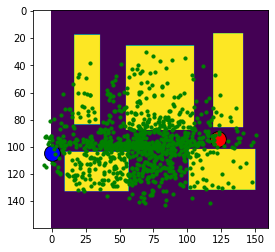

Iter: 401000
Loss: 0.003064

Iter: 402000
Loss: 0.003072

Iter: 403000
Loss: 0.00303

Iter: 404000
Loss: 0.003055

Iter: 405000
Loss: 0.00298

Iter: 406000
Loss: 0.002948

Iter: 407000
Loss: 0.003046

Iter: 408000
Loss: 0.003083

Iter: 409000
Loss: 0.003024

Iter: 410000
Loss: 0.003101



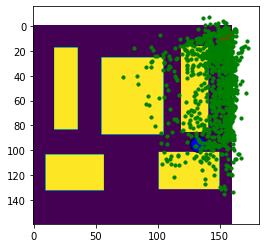

Iter: 411000
Loss: 0.003267

Iter: 412000
Loss: 0.003128

Iter: 413000
Loss: 0.002941

Iter: 414000
Loss: 0.003058

Iter: 415000
Loss: 0.002994

Iter: 416000
Loss: 0.003139

Iter: 417000
Loss: 0.002925

Iter: 418000
Loss: 0.002948

Iter: 419000
Loss: 0.003045

Iter: 420000
Loss: 0.003035



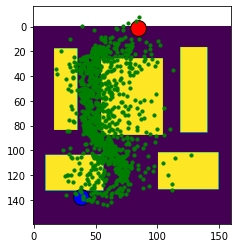

Iter: 421000
Loss: 0.003154

Iter: 422000
Loss: 0.002986

Iter: 423000
Loss: 0.003021

Iter: 424000
Loss: 0.003001

Iter: 425000
Loss: 0.003084

Iter: 426000
Loss: 0.003014

Iter: 427000
Loss: 0.003074

Iter: 428000
Loss: 0.003027

Iter: 429000
Loss: 0.003001

Iter: 430000
Loss: 0.003037



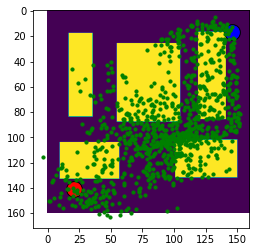

Iter: 431000
Loss: 0.003096

Iter: 432000
Loss: 0.003137

Iter: 433000
Loss: 0.003029

Iter: 434000
Loss: 0.003141

Iter: 435000
Loss: 0.003044

Iter: 436000
Loss: 0.003024

Iter: 437000
Loss: 0.002944

Iter: 438000
Loss: 0.00312

Iter: 439000
Loss: 0.003037

Iter: 440000
Loss: 0.003065



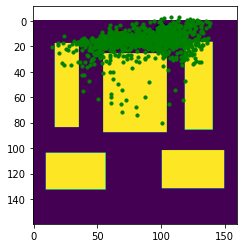

Iter: 441000
Loss: 0.002989

Iter: 442000
Loss: 0.003078

Iter: 443000
Loss: 0.002907

Iter: 444000
Loss: 0.00331

Iter: 445000
Loss: 0.002983

Iter: 446000
Loss: 0.00308

Iter: 447000
Loss: 0.002977

Iter: 448000
Loss: 0.002897

Iter: 449000
Loss: 0.002982

Iter: 450000
Loss: 0.003001



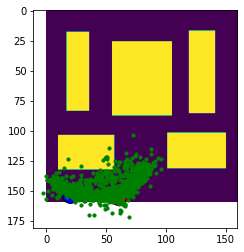

Iter: 451000
Loss: 0.00298

Iter: 452000
Loss: 0.003066

Iter: 453000
Loss: 0.002998

Iter: 454000
Loss: 0.002933

Iter: 455000
Loss: 0.002916

Iter: 456000
Loss: 0.00296

Iter: 457000
Loss: 0.002891

Iter: 458000
Loss: 0.00295

Iter: 459000
Loss: 0.002976

Iter: 460000
Loss: 0.003041



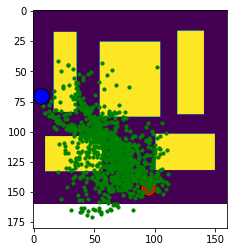

Iter: 461000
Loss: 0.003047

Iter: 462000
Loss: 0.003007

Iter: 463000
Loss: 0.002885

Iter: 464000
Loss: 0.002854

Iter: 465000
Loss: 0.0032

Iter: 466000
Loss: 0.002934

Iter: 467000
Loss: 0.002993

Iter: 468000
Loss: 0.003211

Iter: 469000
Loss: 0.003122

Iter: 470000
Loss: 0.002929



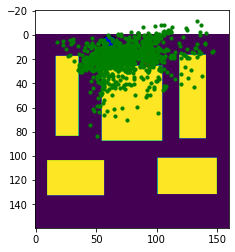

Iter: 471000
Loss: 0.003203

Iter: 472000
Loss: 0.002862

Iter: 473000
Loss: 0.002903

Iter: 474000
Loss: 0.00293

Iter: 475000
Loss: 0.002947

Iter: 476000
Loss: 0.002853

Iter: 477000
Loss: 0.00295

Iter: 478000
Loss: 0.003022

Iter: 479000
Loss: 0.003071

Iter: 480000
Loss: 0.003009



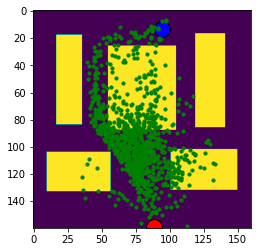

Iter: 481000
Loss: 0.002916

Iter: 482000
Loss: 0.002924

Iter: 483000
Loss: 0.003062

Iter: 484000
Loss: 0.002891

Iter: 485000
Loss: 0.002928

Iter: 486000
Loss: 0.002938

Iter: 487000
Loss: 0.002862

Iter: 488000
Loss: 0.00299

Iter: 489000
Loss: 0.003037

Iter: 490000
Loss: 0.002957



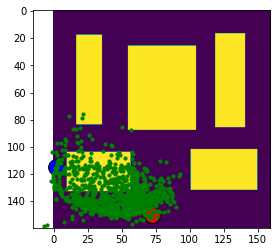

Iter: 491000
Loss: 0.002959

Iter: 492000
Loss: 0.002989

Iter: 493000
Loss: 0.003011

Iter: 494000
Loss: 0.003005

Iter: 495000
Loss: 0.002995

Iter: 496000
Loss: 0.002933

Iter: 497000
Loss: 0.003055

Iter: 498000
Loss: 0.00299

Iter: 499000
Loss: 0.002848



In [16]:
# Train  model and save weights after each ITERS_PER_SAVE
saver = tf.train.Saver()
for i in range(it, TRAIN_ITERS):
    # randomly generate batches
    batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
    X_mb = x_train[batch_elements,:]
    c_mb = cond_train[batch_elements,:]

    _, loss = sess.run([train_step, cvae_loss], feed_dict={X: X_mb, c: c_mb})

    if i % 1000 == 0:
        print('Iter: {}'.format(i))
        print('Loss: {:.4}'. format(loss))
        print()
    if i % ITERS_PER_SAVE == 0:
      saver.save(sess, MODEL_DIR+'/model_for_map_iter%d' % (i), write_meta_graph=False)
      NUM_SAMPLES = 1000  # number of samples for model to generate
      rand_test_i = randint(0,numTest-1)
      rand_cond = cond_test[rand_test_i, :]
      init = rand_cond[:STATE_DIM] * SAMPLE_SCALE_UP
      goal = rand_cond[STATE_DIM:2*STATE_DIM] * SAMPLE_SCALE_UP

      # same condition repeated NUM_SAMPLES times
      cond_samples = np.repeat([rand_cond],NUM_SAMPLES,axis=0)  

      # directly sample from the latent space to generate predicted samples
      gen_samples, _ = sess.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
      # scale up samples to original map dimension
      gen_samples = gen_samples * SAMPLE_SCALE_UP

      plt.imshow(orig_map)
      plt.scatter(x=init[1], y=init[0], color="red", s=250, edgecolors='black') # init
      plt.scatter(x=goal[1], y=goal[0], color="blue", s=250, edgecolors='black') # goal
      plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color="green", s=10) # samples

      plt.show()


# Testing 

In [7]:
tf.reset_default_graph()
# Testing initialisation
sess_test = tf.Session()
# sess_test.run(tf.initialize_all_variables())
saver = tf.train.import_meta_graph(MODEL_DIR+'/graph.meta')
saver = tf.train.Saver()
saver.restore(sess_test, tf.train.latest_checkpoint(MODEL_DIR))
# Add code here to load models

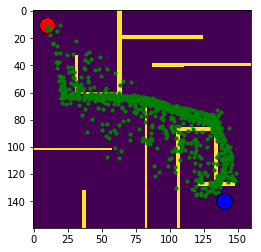

In [9]:

# Now, let's access and create placeholders variables and
# create feed-dict to feed new data
 
NUM_SAMPLES = 1000  # number of samples for model to generate

rand_test_i = randint(0,numTest-1)
rand_cond = cond_test[rand_test_i, :]
rand_cond[:2] = [10/SAMPLE_SCALE_UP,10/SAMPLE_SCALE_UP]
rand_cond[2:4] = [140/SAMPLE_SCALE_UP,140/SAMPLE_SCALE_UP]
init = rand_cond[:STATE_DIM] * SAMPLE_SCALE_UP
goal = rand_cond[STATE_DIM:2*STATE_DIM] * SAMPLE_SCALE_UP

# same condition repeated NUM_SAMPLES times
cond_samples = np.repeat([rand_cond],NUM_SAMPLES,axis=0)  
gen_samples=None
# directly sample from the latent space to generate predicted samples
z = sess_test.graph.get_tensor_by_name('Add:0')
c = sess_test.graph.get_tensor_by_name('c:0')
y = sess_test.graph.get_tensor_by_name('dense_6/BiasAdd:0')
gen_samples, _ = sess_test.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
# scale up samples to original map dimension
gen_samples = gen_samples * SAMPLE_SCALE_UP

plt.imshow(orig_map)
plt.scatter(x=init[1], y=init[0], color="red", s=250, edgecolors='black') # init
plt.scatter(x=goal[1], y=goal[0], color="blue", s=250, edgecolors='black') # goal
plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color="green", s=10) # samples

plt.show()

In [ ]:
[n.name for n in tf.get_default_graph().as_graph_def().node]

In [4]:
import rospy
from sampling_node.msg import Points
from sampling_node.srv import SamplingService, SamplingServiceResponse, SamplingServiceRequest

ModuleNotFoundError: No module named 'sampling_node'

In [10]:
orig_map.shape

(160, 160)

In [5]:
MAP_NUM = 1
DIR = "/home/arcot/Planning_Project/src/CVAE"
MODEL_DIR = DIR+"/Models/0"+str(MAP_NUM)
mini_map_file = os.path.join(DIR+"/Training_Data/", 'map{}_mini.npy'.format(MAP_NUM))
mini_map = np.load(mini_map_file)
map_file = os.path.join(DIR+"/Training_Data/", 'map{}.npy'.format(MAP_NUM))
_map = np.load(map_file)

In [6]:
unrolled_map = np.concatenate(mini_map, axis=0)
rows = _map.shape[0]
cols = _map.shape[1]
sess = None

In [7]:
path = MODEL_DIR
tf.reset_default_graph()
sess = tf.Session()
saver = tf.train.import_meta_graph(path+'/graph.meta')
saver = tf.train.Saver()
saver.restore(sess, tf.train.latest_checkpoint(path))

In [8]:
nos=1000
init = [10,10]
goal = [140,140]

z_dim = 3
NUM_SAMPLES = nos  # number of samples for model to generate
init[0]/=rows
init[1]/=cols
goal[0]/=rows
goal[1]/=cols
cond = np.concatenate([np.array(init+goal), unrolled_map])
# same condition repeated NUM_SAMPLES times
cond_samples = np.repeat([cond],NUM_SAMPLES,axis=0)  
# directly sample from the latent space to generate predicted samples
z = sess.graph.get_tensor_by_name('Add:0')
c = sess.graph.get_tensor_by_name('c:0')
y = sess.graph.get_tensor_by_name('dense_6/BiasAdd:0')
gen_samples, _ = sess.run([y, z], feed_dict={z: np.random.randn(NUM_SAMPLES, z_dim), c: cond_samples})
gen_samples[:,0]*=rows
gen_samples[:,1]*=cols

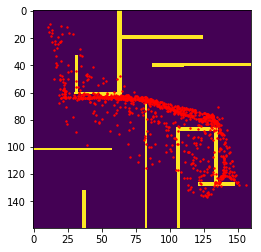

In [9]:
plt.imshow(_map)
plt.scatter(x=gen_samples[:,1], y=gen_samples[:,0], color='red',s=2)

In [22]:
unrolled_map.shape

(25600,)